In [189]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
import numpy as np

from warnings import filterwarnings
filterwarnings("ignore")
sns.set_style("whitegrid")  # 'white', 'dark', 'whitegrid', 'darkgrid', 'ticks'
sns.set_theme(palette='muted')

In [190]:
cali_df_temp = fetch_california_housing(as_frame=True)

cali_housing_samples : pd.DataFrame = cali_df_temp['data']
cali_housing_targets : pd.DataFrame = cali_df_temp['target']

# Grid Search to find best parameters for the Decision Tree 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(cali_housing_samples, cali_housing_targets, test_size=0.2, random_state=100, shuffle=True)

model = DecisionTreeRegressor(criterion='squared_error', random_state=100)

param_grid = {
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10 , 15, 20],
    'max_features': [None, 'sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train.astype(np.float64), y_train.astype(np.float64))

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10, 12, 15, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='neg_mean_squared_error', verbose=1)

# Decision Tree with the best parameters from the grid search

In [192]:
print(grid.best_params_)
print(-grid.best_score_)

dt = DecisionTreeRegressor(
    max_depth=grid.best_params_['max_depth'],
    max_features=grid.best_params_['max_features'],
    min_samples_leaf=grid.best_params_['min_samples_leaf'],
    min_samples_split=grid.best_params_['min_samples_leaf'],
)

dt.fit(X_train, y_train)

{'max_depth': 15, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 2}
0.39141524864471


DecisionTreeRegressor(max_depth=15, min_samples_leaf=15, min_samples_split=15)

In [193]:
predicted_y_dt = dt.predict(X_test)

# Checking if it overfits

In [194]:
train_preds = dt.predict(X_train)
print(f'Training R2 score: {r2_score(y_train, train_preds):.2f}')
print(f'Testing R2 score: {r2_score(y_test, predicted_y_dt):.2f}')

print(f'\nTraining mse:  {mean_squared_error(y_train, train_preds):.2f}')
print(f'Testing mse:  {mean_squared_error(y_test, predicted_y_dt):.2f}')

Training R2 score: 0.83
Testing R2 score: 0.74

Training mse:  0.22
Testing mse:  0.35


# Scoring (with all features)

In [195]:
r_squared = r2_score(y_true=y_test, y_pred=predicted_y_dt)
mse = mean_squared_error(y_true=y_test, y_pred=predicted_y_dt)
rmse = root_mean_squared_error(y_true = y_test, y_pred = predicted_y_dt)
mae = mean_absolute_error(y_true = y_test, y_pred = predicted_y_dt)

print(f'R2 score: {r_squared:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean square error: {rmse:.2f}')
print(f'Mean Absolute error: {mae:.2f}')

R2 score: 0.74
Mean squared error: 0.35
Root mean square error: 0.59
Mean Absolute error: 0.40


Linear Regression Results:
  - R2 score: 0.64
  - Mean squared error: 0.43
  - Root mean square error: 0.65
  - Mean Absolute error: 0.49

# Barplot of feature importances

MedInc: 0.58
HouseAge: 0.05
AveRooms: 0.01
AveBedrms: 0.01
Population: 0.01
AveOccup: 0.15
Latitude: 0.10
Longitude: 0.10


Text(0.5, 1.0, 'Feature importance from Decision Tree (all features)')

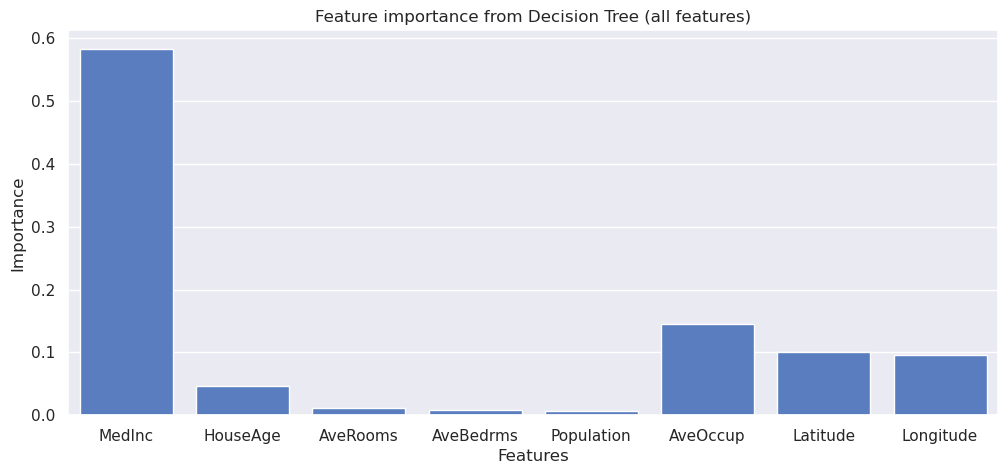

In [196]:
for column, importance in zip(dt.feature_names_in_, dt.feature_importances_):
    print(f'{column}: {importance:.2f}')

plt.figure(figsize=(12, 5))
sns.barplot(x=X_train.columns, y=dt.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance from Decision Tree (all features)')

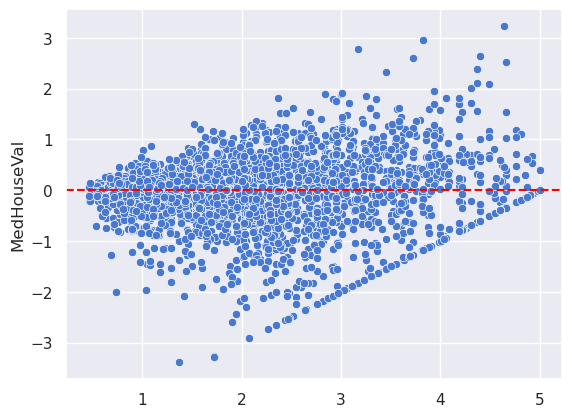

In [197]:
residuals = predicted_y_dt - y_test
sns.scatterplot(x=predicted_y_dt, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')

# Removing low impact features

In [198]:

new_X = cali_housing_samples.drop(['Population', 'AveRooms', 'AveBedrms'], axis=1)

low_impact_features = ['Population', 'AveRooms', 'AveBedrms']
cali_housing_samples[low_impact_features].var()

variance_of_low_impact_features = cali_housing_samples[low_impact_features].var()

for column_name, var in zip(low_impact_features, variance_of_low_impact_features):
    print(f'{column_name}: {var:.2f}')

Population: 1282470.46
AveRooms: 6.12
AveBedrms: 0.22


# Grid Search again after the removal of low impact features

In [199]:
X_train_dropped_cols, X_test_dropped_cols, y_train, y_test = train_test_split(new_X, cali_housing_targets, test_size=0.2, random_state=100, shuffle=True)

model = DecisionTreeRegressor(criterion='squared_error', random_state=100)

param_grid = {
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10 , 15, 20],
    'max_features': [None, 'sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train_dropped_cols.astype(np.float64), y_train.astype(np.float64))

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10, 12, 15, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='neg_mean_squared_error', verbose=1)

# Decision Tree with the best parameters from the grid search<br>
# (After removal of low impact features)

In [200]:
print(grid.best_params_)
print(-grid.best_score_)

dt = DecisionTreeRegressor(
    max_depth=grid.best_params_['max_depth'],
    max_features=grid.best_params_['max_features'],
    min_samples_leaf=grid.best_params_['min_samples_leaf'],
    min_samples_split=grid.best_params_['min_samples_leaf'],
)

dt.fit(X_train_dropped_cols, y_train)
predicted_y_dt_best = dt.predict(X_test_dropped_cols)

{'max_depth': 12, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 2}
0.3526292720066238


# Checking if it overfits

In [201]:
training_predictions = dt.predict(X_train_dropped_cols)

print(f'Training R2 score: {r2_score(y_train, training_predictions):.2f}')
print(f'Testing R2 score:  {r2_score(y_test, predicted_y_dt):.2f}')

print(f'\nTraining mse:  {mean_squared_error(y_train, training_predictions):.2f}')
print(f'Testing mse: {mean_squared_error(y_test, predicted_y_dt):.2f}')

Training R2 score: 0.82
Testing R2 score:  0.74

Training mse:  0.24
Testing mse: 0.35


In [202]:
r_squared = r2_score(y_true=y_test, y_pred=predicted_y_dt_best)
mse = mean_squared_error(y_true=y_test, y_pred=predicted_y_dt_best)
rmse = root_mean_squared_error(y_true = y_test, y_pred = predicted_y_dt_best)
mae = mean_absolute_error(y_true = y_test, y_pred = predicted_y_dt_best)

print(f'R2 score: {r_squared:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean square error: {rmse:.2f}')
print(f'Mean Absolute error: {mae:.2f}')

R2 score: 0.75
Mean squared error: 0.33
Root mean square error: 0.58
Mean Absolute error: 0.38


Linear Regression Results:
  - R2 score: 0.64
  - Mean squared error: 0.43
  - Root mean square error: 0.65
  - Mean Absolute error: 0.49

### Results: All the scores are exactly the same as before removing low impact features

Decision tree naturally ignore features with low impact on the model. Hence, removing them won't affect the performance of the model

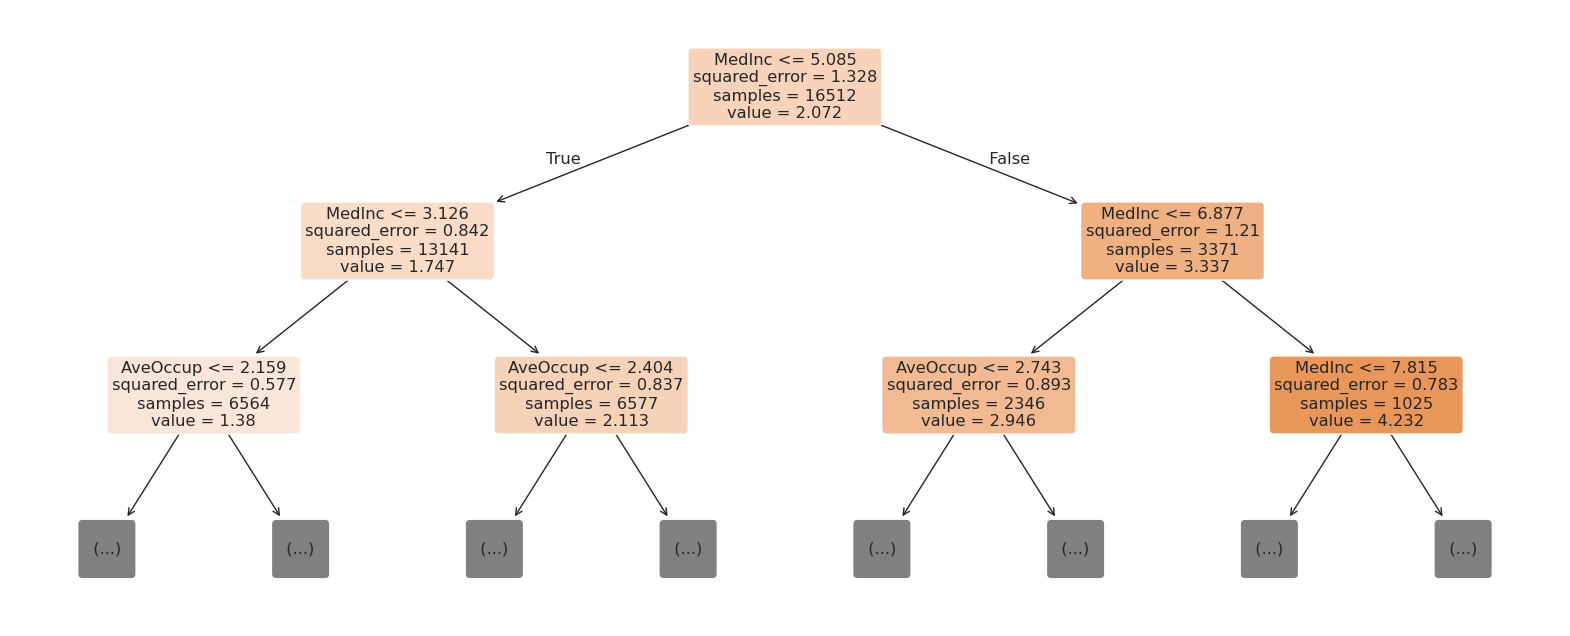

In [203]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 8))
plot_tree(dt, feature_names=dt.feature_names_in_,
          filled=True,
          rounded=True,
          max_depth=2
);

# Barplot of feature importances
# (After removal of low impact features)

MedInc: 0.59
HouseAge: 0.05
AveOccup: 0.15
Latitude: 0.11
Longitude: 0.10


[Text(0, 0, '0.591726'),
 Text(0, 0, '0.150289'),
 Text(0, 0, '0.10718'),
 Text(0, 0, '0.104822'),
 Text(0, 0, '0.0459829')]

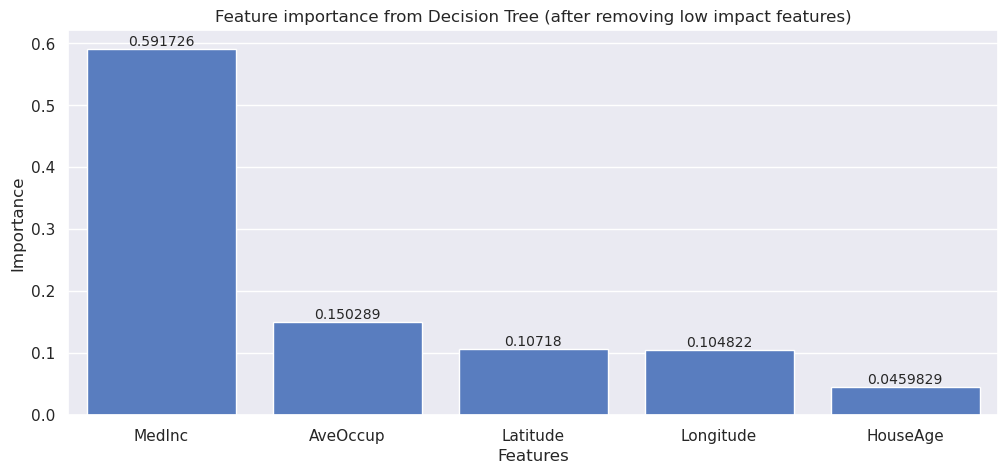

In [204]:
for column, importance in zip(dt.feature_names_in_, dt.feature_importances_):
    print(f'{column}: {importance:.2f}')

sorted_feature_importance : pd.DataFrame = pd.DataFrame(
    data={'Features': dt.feature_names_in_, 'Importance': dt.feature_importances_}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 5))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance from Decision Tree (after removing low impact features)')

ax = sns.barplot(data=sorted_feature_importance, x='Features', y='Importance', estimator='sum')
ax.bar_label(ax.containers[0], fontsize=10)

# Residuals plot

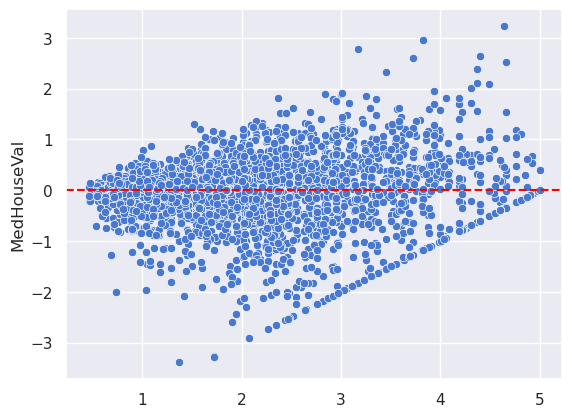

In [205]:
residuals = predicted_y_dt - y_test
sns.scatterplot(x=predicted_y_dt, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')

---

# <p align='center'><font color='cyan'> Random Forest </font> </p>


In [221]:
from sklearn.ensemble import RandomForestRegressor

Cross validation for the parameters of the Random Forest

In [206]:
rfr = RandomForestRegressor(
    max_depth=7,
).fit(X_train, y_train)
preds = rfr.predict(X_test)

feature_importance = rfr.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

testing_preds = rfr.predict(X_test)
training_preds = rfr.predict(X_train)

print('Training R2 score: ', r2_score(y_train, training_preds))
print('Testing R2 score: ', r2_score(y_test, testing_preds))

print('Training mse: ', mean_squared_error(y_train, training_preds))
print('Testing mse: ', mean_squared_error(y_test, testing_preds))

Training R2 score:  0.7588748129997466
Testing R2 score:  0.7321643678905403
Training mse:  0.32010419508762566
Testing mse:  0.3608809958085305


MedInc: 0.68
HouseAge: 0.05
AveRooms: 0.02
AveBedrms: 0.01
Population: 0.01
AveOccup: 0.14
Latitude: 0.05
Longitude: 0.04


Text(0.5, 1.0, 'Feature importance from Random Forest')

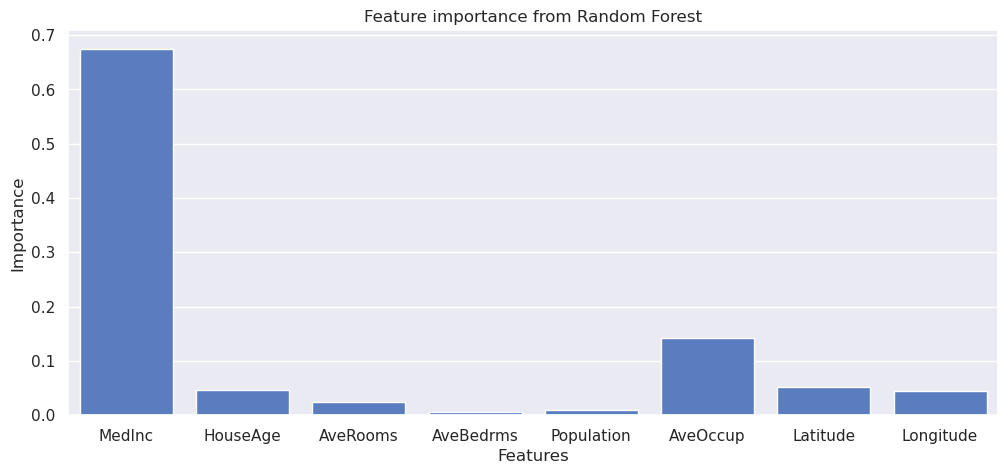

In [207]:
for column, importance in zip(X_train.columns, feature_importance):
    print(f'{column}: {importance:.2f}')

plt.figure(figsize=(12, 5))
sns.barplot(data=importance_df, x=X_train.columns, y=feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance from Random Forest')